In [1]:
import numpy as np
import netCDF4 as nc # used for reading netCDF4 data
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
#from sklearn import neighbors
#from sklearn.metrics import mean_squared_error 
from math import sqrt
import glob
import os, sys, stat
import datetime   # Used for comparing dates with each other

import pickle  # for saving intermediate datasets
import logging

from sklearn.linear_model import LinearRegression # For simple linear regression
from sklearn import metrics #r2_score

In [44]:
pers_dat_dir = '/projects/0/ctdas/awoude/Ritten/' # For data specifically stored for my perfonal usage
pers_file_dir = '/gpfs/work1/0/ctdas/awoude/Ritten/' # For storing and retrieving my own data files


SF_FILES = sorted(glob.glob(pers_dat_dir + 'flux_data/flux1x1_20??????00_20??????00.nc'))

pred_var_path = '/gpfs/work1/0/ctdas/awoude/Ritten/predictor_vars/' # For retrieving the set of aggregated scaling vectors
ds_ready_for_transport_dir = pers_file_dir + 'transport/'


logging.basicConfig(filename='logs/ML-implementations.log', format='%(asctime)s - %(message)s', level=logging.INFO)

regionsfile = '/gpfs/home5/awoude/Ritten/EKF/regions.nc' # Contains the data on the distribution of ecoregions

state_vec_file = '/projects/0/ctdas/input/ctdas_2012/covariances/gridded_NH/griddedNHparameters.nc'

NPARAMS = 9835

#/projects/0/ctdas/awoude/Ritten/transport_results


In [3]:
with xr.open_dataset(SF_FILES[0]) as ds:
    print(ds.flux_bio_prior_mean)

<xarray.DataArray 'flux_bio_prior_mean' (lat: 180, lon: 360)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    units:             mol m-2 s-1
    flux_bio_prior_n:  168


In [3]:
# Get the regions in a dict

with nc.Dataset(regionsfile) as ds:
    tc_names = [b''.join(n).decode().strip() for n in ds['transcom_names'][:]]
    transcom_regions = ds['transcom_regions'][:]
    tc_region_inds = sorted(np.unique(transcom_regions))
    tc_dict = {}
    eco_tc_dict = {}
    for r, name in zip(tc_region_inds, tc_names):
        mask = np.where(transcom_regions==r, 1, 0)
        tc_dict[name] = mask
        ecoregions = np.where(mask, ds['regions'][:],0)
        for r in np.unique(ecoregions)[1:]:
            eco_tc_dict[str(r)] = name
    eco_tc_da = xr.DataArray(name='tc_region', data=list(eco_tc_dict.values()), dims=['ecoregion'], coords={'ecoregion':list(eco_tc_dict.keys())})        
    all_regions = ds['regions'][:]
    unique_regions = np.unique(all_regions)
    print(unique_regions)
    all_region_matrix = np.zeros((round(np.max(unique_regions)), 180, 360))
    for r in unique_regions:
        mask = np.where(all_regions==r, 1, 0)
        all_region_matrix[round(r)-1] = mask
    all_regiondict = {}
    for r in unique_regions:
        mask = np.where(all_regions==r, 1, 0)
        all_regiondict[r] = mask

/scratch-local/awoude/ipykernel_2900145/352254457.py:4: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  tc_names = [b''.join(n).decode().strip() for n in ds['transcom_names'][:]]


[  1.   3.   4.   7.   8.   9.  10.  11.  15.  16.  19.  20.  21.  22.
  23.  24.  25.  26.  27.  29.  30.  31.  32.  33.  34.  35.  38.  39.
  40.  41.  42.  43.  45.  46.  48.  49.  50.  51.  52.  57.  59.  60.
  61.  62.  63.  64.  65.  67.  68.  69.  70.  71.  73.  76.  78.  79.
  80.  81.  82.  83.  84.  86.  87.  88.  89.  90.  93.  95.  97.  98.
  99. 100. 101. 102. 103. 105. 106. 107. 108. 109. 112. 114. 115. 116.
 117. 118. 121. 122. 123. 124. 125. 128. 130. 133. 134. 135. 136. 137.
 138. 139. 140. 141. 143. 144. 145. 146. 147. 152. 154. 155. 156. 157.
 160. 162. 163. 166. 171. 172. 173. 174. 175. 176. 177. 178. 179. 181.
 183. 185. 187. 190. 191. 192. 193. 194. 195. 196. 197. 198. 199. 200.
 201. 202. 204. 206. 209. 210. 211. 212. 213. 214. 215. 216. 217. 218.
 219. 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231. 232.
 233. 234. 235. 236. 237. 238. 239. 240.]


In [80]:
def get_scaling_factor_er(f):
    """Calculate the scaling factor for a file for every eco region"""
    # s = pd.Series(dtype='float64')
    with xr.open_dataset(f) as ds:
        sf_total = ds['flux_multiplier_m']
        s = {}
        #print(np.shape(sf_total))
        for name, mask in all_regiondict.items():
            #print(np.sum(mask[70]))
            #print(f"eco region {name} has unique scaling factors {np.unique((sf_total * mask))}")
            masked_df = np.where(mask, sf_total, np.nan)
            if np.all(np.isnan(masked_df)):
                sf_region = np.nan
                print(f'region {name} is empty')
            else:
                sf_region = np.nanmean(masked_df)
            
            s[str(name)] = sf_region
    return xr.DataArray(name='sf', data=list(s.values()), dims=['ecoregion'], coords={'ecoregion':list(s.keys())})


def get_state_vec(f, state_elem_ds):
    with xr.open_dataset(f) as ds:
        sf_total  = ds['flux_multiplier_m']
        # combined dataset in which the elements of the state vector and the scaling vectors are aligned based on longitude and latitude
        comb = state_elem_ds.merge(sf_total)
        gr = comb.groupby('regions').max()['flux_multiplier_m'] # All values should be the same, so taking the max or min should not make a difference
        return gr
    

def extract_date(f):
    date_hours = f.split('_')[-2] # extracting the first day of the week
    date = date_hours[:-2] # removing the final two number prepresenting the hours (?)
    return pd.to_datetime(date) # parse the date into the correct data type

def calc_area(lats, lons):
    ''' Calculates the surface area [m2]of a grid spanned by lon and lat.
    Assumes lon,lat are evenly spaced (in degrees) vectors.
    Assumes lon,lat indicate center points
    Assumes the globe is a perfect sphere.
    Written by M Molen'''
    R            = 6370e3 # [m] the radius of the earth and h is the perpendicular distance from the plane containing the line of latitude to the pole.
    # grid spacing (degrees)
    dlon         = np.gradient(lons).mean()
    dlat         = np.gradient(lats).mean()
    # initialize A (surface area of grid point)
    nlon         = len(lons)
    nlat         = len(lats)
    A            = np.zeros((nlat, nlon))
    for iy in range(nlat):
        Alat     = 2*np.pi*np.square(R) * np.abs( np.sin(2*np.pi*(lats[iy]-dlat/2.)/360.) -np.sin(2*np.pi*(lats[iy]+dlat/2.)/360.)) * np.abs(dlon)/360. # m2
        A[iy, :] = Alat
    return A # m2


In [5]:
state_vec_file = '/projects/0/ctdas/input/ctdas_2012/covariances/gridded_NH/griddedNHparameters.nc'

with xr.open_dataset(state_vec_file) as state_elem_ds:
    
    state_elements = np.unique(state_elem_ds.regions)
    print(f'total amount of elements within the statevector: {len(state_elements)}')
    
    missing = [i for i in np.arange(1,9836) if i not in state_elements]

print(f'missing elements: {missing}')
print(f'# of missing elements: {len(missing)}')

total amount of elements within the statevector: 9798
missing elements: [9696, 9699, 9705, 9706, 9707, 9708, 9710, 9718, 9724, 9726, 9727, 9729, 9737, 9743, 9744, 9746, 9748, 9756, 9762, 9763, 9765, 9767, 9772, 9773, 9775, 9778, 9779, 9781, 9782, 9783, 9784, 9794, 9796, 9798, 9800, 9802, 9803]
# of missing elements: 37


In [5]:
with xr.open_dataset(regionsfile) as ds:
    ecoregion_da = ds[['regions','grid_cell_area']]
    
with xr.open_dataset(state_vec_file) as ds:
    state_vec_params = ds
    # fixing minor error in the naming of dimensions in the source file:
    ds = ds.swap_dims({"longitude": "lon2", "latitude":"lat2", "lon":"lon2", "lat":"lat2"})
    ds = ds.swap_dims({"lon2": "lon", "lat2":"lat"})
    ds = ds.reset_coords(names=['longitude' ,'latitude'], drop=True)
    ds = ds.rename({'regions':'state_elem'})
    
    state_elem_da = ds['state_elem']

with xr.open_dataset(pred_var_path+'36-params_2000-2020.nc') as ds:
    print(ecoregion_da)
    ds['s10m_AVG'] = np.sqrt(ds.u10m_AVG*ds.u10m_AVG+ds.v10m_AVG*ds.v10m_AVG)
    new_ds = ds.merge(ecoregion_da)
    new_ds = new_ds.merge(state_elem_da)
    
#     grouped_data=new_ds.groupby('regions')
#     print(grouped_data.mean())

/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'ecosystem_names' has multiple fill values {'-', b'-'}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'transcom_names' has multiple fill values {'-', b'-'}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:         (lat: 180, lon: 360)
Coordinates:
  * lon             (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    regions         (lat, lon) float32 ...
    grid_cell_area  (lat, lon) float32 ...
Attributes:
    Notes:        This file contains CarbonTracker regional definitions.
    disclaimer:   CarbonTracker is an open product of the NOAA Earth System R...
    email:        carbontracker.team@noaa.gov
    url:          http://carbontracker.noaa.gov
    institution:  NOAA Earth System Research Laboratory
    Conventions:  CF-1.1
    history:      Created on Thu Mar 24 2011 22:24:54 GMT\nby script 'Time-st...
    Source:       CarbonTracker release CT2010


In [23]:
new_ds

<xarray.Dataset>
Dimensions:         (time: 1096, lat: 180, lon: 360)
Coordinates:
  * time            (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2020-12-26
  * lon             (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables: (12/40)
    g10m_MAX        (time, lat, lon) float32 6.732 6.732 6.732 ... 17.75 17.75
    swvl1_MIN       (time, lat, lon) float32 ...
    swvl1_MAX       (time, lat, lon) float32 ...
    slhf_MIN        (time, lat, lon) float32 ...
    slhf_MAX        (time, lat, lon) float32 ...
    slhf_AVG        (time, lat, lon) float32 ...
    ...              ...
    sf_AVG          (time, lat, lon) float32 ...
    sf_MAX          (time, lat, lon) float32 ...
    s10m_AVG        (time, lat, lon) float32 2.005 2.005 2.005 ... 1.887 1.887
    regions         (lat, lon) float32 240.0 240.0 240.0 ... 210.0 210.0 210.0
    grid_cell_area  (lat, lon) float32 1.079e+08 1.079e+08 ... 1.079e+08
    state_elem      (lat, lon) float32 9.835e+03 9.835e+03 ... 9.805e+03

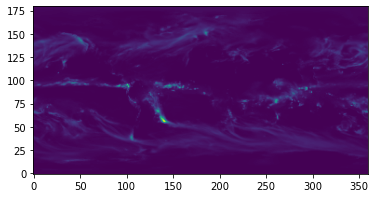

In [21]:
plt.imshow(new_ds.lsp_SUM['time'==10], origin='lower')

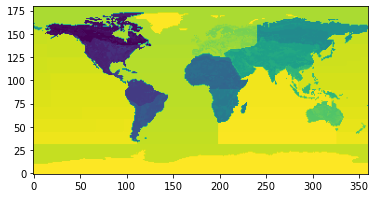

In [22]:
plt.imshow(new_ds.regions, origin='lower')

In [5]:
params = new_ds.variables.mapping.keys()
print(params)

MAX_params = [p for p in params if 'MAX' in p]
MAX_params.append('state_elem')
MIN_params = [p for p in params if 'MIN' in p]
MIN_params.append('state_elem')
AVG_params = [p for p in params if 'AVG' in p]

SUM_params = [p for p in params if 'SUM' in p]
SUM_params.append('grid_cell_area')
print([MAX_params,MIN_params,AVG_params,SUM_params])

dict_keys(['g10m_MAX', 'swvl1_MIN', 'swvl1_MAX', 'slhf_MIN', 'slhf_MAX', 'slhf_AVG', 'sshf_MIN', 'sshf_MAX', 'sshf_AVG', 'ssrd_MIN', 'ssrd_MAX', 'ssrd_AVG', 'u10m_AVG', 'v10m_AVG', 'blh_MAX', 'd2m_MIN', 'd2m_MAX', 'd2m_AVG', 'lsp_SUM', 'skt_MIN', 'skt_MAX', 'skt_AVG', 'src_MIN', 'src_AVG', 'ssr_MAX', 'ssr_AVG', 't2m_MIN', 't2m_MAX', 't2m_AVG', 'ci_AVG', 'cp_MAX', 'cp_SUM', 'sd_MIN', 'sd_MAX', 'sf_AVG', 'sf_MAX', 'time', 'lon', 'lat', 's10m_AVG', 'regions', 'grid_cell_area', 'state_elem'])
[['g10m_MAX', 'swvl1_MAX', 'slhf_MAX', 'sshf_MAX', 'ssrd_MAX', 'blh_MAX', 'd2m_MAX', 'skt_MAX', 'ssr_MAX', 't2m_MAX', 'cp_MAX', 'sd_MAX', 'sf_MAX', 'state_elem'], ['swvl1_MIN', 'slhf_MIN', 'sshf_MIN', 'ssrd_MIN', 'd2m_MIN', 'skt_MIN', 'src_MIN', 't2m_MIN', 'sd_MIN', 'state_elem'], ['slhf_AVG', 'sshf_AVG', 'ssrd_AVG', 'u10m_AVG', 'v10m_AVG', 'd2m_AVG', 'skt_AVG', 'src_AVG', 'ssr_AVG', 't2m_AVG', 'ci_AVG', 'sf_AVG', 's10m_AVG'], ['lsp_SUM', 'cp_SUM', 'grid_cell_area']]


In [49]:
new_ds[SUM_params].groupby(new_ds.regions).sum()

<xarray.Dataset>
Dimensions:         (regions: 176, time: 1096)
Coordinates:
  * regions         (regions) float64 1.0 3.0 4.0 7.0 ... 238.0 239.0 240.0
  * time            (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2020-12-26
Data variables:
    lsp_SUM         (regions, time) float32 0.001198 0.0009805 ... 0.005706
    cp_SUM          (regions, time) float32 9.908e-05 7.162e-05 ... 0.0002895
    grid_cell_area  (regions) float32 2.315e+12 5.923e+11 ... 1.598e+13

In [38]:
np.sqrt(new_ds.u10m_AVG*new_ds.u10m_AVG+new_ds.v10m_AVG*new_ds.v10m_AVG)

<xarray.DataArray (time: 1096, lat: 180, lon: 360)>
array([[[2.0047934, 2.0047934, 2.0047934, ..., 1.9985521, 1.9985521,
         1.9985521],
        [3.5426388, 3.5426388, 3.5426388, ..., 3.4880285, 3.4880285,
         3.4880285],
        [5.4074597, 5.4074597, 5.4074597, ..., 5.4096417, 5.4096417,
         5.4096417],
        ...,
        [8.945083 , 8.945083 , 8.945083 , ..., 8.94836  , 8.94836  ,
         8.94836  ],
        [9.081614 , 9.081614 , 9.081614 , ..., 9.1492405, 9.1492405,
         9.1492405],
        [9.129685 , 9.129685 , 9.129685 , ..., 9.16658  , 9.16658  ,
         9.16658  ]],

       [[4.8127294, 4.8127294, 4.8127294, ..., 4.8190184, 4.8190184,
         4.8190184],
        [5.4213905, 5.4213905, 5.4213905, ..., 5.261866 , 5.261866 ,
         5.261866 ],
        [6.1517906, 6.1517906, 6.1517906, ..., 6.147951 , 6.147951 ,
         6.147951 ],
...
        [5.708317 , 5.708317 , 5.708317 , ..., 5.707277 , 5.707277 ,
         5.707277 ],
        [5.754285 , 5.754285 , 5.754285 , ..., 5.739887 , 5.739887 ,
         5.739887 ],
        [5.804891 , 5.804891 , 5.804891 , ..., 5.8050094, 5.8050094,
         5.8050094]],

       [[2.9140089, 2.9140089, 2.9140089, ..., 2.9487658, 2.9487658,
         2.9487658],
        [4.3948717, 4.3948717, 4.3948717, ..., 4.291724 , 4.291724 ,
         4.291724 ],
        [6.1767406, 6.1767406, 6.1767406, ..., 6.1747446, 6.1747446,
         6.1747446],
        ...,
        [1.302398 , 1.302398 , 1.302398 , ..., 1.3006681, 1.3006681,
         1.3006681],
        [1.3171835, 1.3171835, 1.3171835, ..., 1.2638866, 1.2638866,
         1.2638866],
        [1.8870655, 1.8870655, 1.8870655, ..., 1.8873006, 1.8873006,
         1.8873006]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2020-12-26
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [40]:
new_ds

<xarray.Dataset>
Dimensions:         (time: 1096, lat: 180, lon: 360)
Coordinates:
  * time            (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2020-12-26
  * lon             (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat             (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables: (12/40)
    g10m_MAX        (time, lat, lon) float32 ...
    swvl1_MIN       (time, lat, lon) float32 ...
    swvl1_MAX       (time, lat, lon) float32 ...
    slhf_MIN        (time, lat, lon) float32 ...
    slhf_MAX        (time, lat, lon) float32 ...
    slhf_AVG        (time, lat, lon) float32 ...
    ...              ...
    sf_AVG          (time, lat, lon) float32 ...
    sf_MAX          (time, lat, lon) float32 ...
    regions         (lat, lon) float32 240.0 240.0 240.0 ... 210.0 210.0 210.0
    grid_cell_area  (lat, lon) float32 1.079e+08 1.079e+08 ... 1.079e+08
    state_elem      (lat, lon) float32 9.835e+03 9.835e+03 ... 9.805e+03
    s10m_AVG        (time, lat, lon) float32 2.005 2.005 2.005 ... 1.887 1.887

<xarray.DataArray 'v10m_AVG' (time: 1096, lat: 180, lon: 360)>
[71020800 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2020-12-26
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

<xarray.Dataset>
Dimensions:                    (lon: 360, lat: 180,
                                carbontracker_240_regions: 240,
                                dim_transcom23: 23, dim_eco19: 19,
                                dim_ocean30: 30, string_of_60chars: 60,
                                string_of_25chars: 25)
Coordinates:
  * lon                        (lon) float64 -179.5 -178.5 ... 178.5 179.5
  * lat                        (lat) float64 -89.5 -88.5 -87.5 ... 88.5 89.5
  * carbontracker_240_regions  (carbontracker_240_regions) int32 1 2 ... 239 240
  * dim_transcom23             (dim_transcom23) int32 1 2 3 4 5 ... 20 21 22 23
  * dim_eco19                  (dim_eco19) int32 1 2 3 4 5 6 ... 15 16 17 18 19
  * dim_ocean30                (dim_ocean30) int32 1 2 3 4 5 ... 26 27 28 29 30
  * string_of_60chars          (string_of_60chars) int32 1 2 3 4 ... 57 58 59 60
  * string_of_25chars          (string_of_25chars) int32 1 2 3 4 ... 22 23 24 25
Data variables:
    grid_

/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'ecosystem_names' has multiple fill values {'-', b'-'}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/awoude/.conda/envs/Ritten_3.9.10/lib/python3.9/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'transcom_names' has multiple fill values {'-', b'-'}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


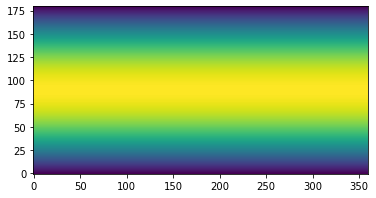

In [5]:
with xr.open_dataset(regionsfile) as ds:
    print(ds)
    plt.imshow(ds.grid_cell_area, origin='lower')

In [6]:
import time
# Combine all scaling factors together in a dataframe
now = time.time()
file_name = 'weekly_sv.nc'
file_path = pers_file_dir + file_name
with xr.open_dataset(state_vec_file) as ds:
    state_vec_params = ds
    # fixing minor error in the naming of dimensions in the source file:
    ds = ds.swap_dims({"longitude": "lon2", "latitude":"lat2", "lon":"lon2", "lat":"lat2"})
    ds = ds.swap_dims({"lon2": "lon", "lat2":"lat"})
    ds = ds.reset_coords(names=['longitude' ,'latitude'], drop=True)
    
    state_elem_ds = ds
ds = xr.Dataset(None)
sv = {}
for i, f in enumerate(SF_FILES[:5]):
    with xr.open_dataset(f) as ds:
        print(f"Currently processing file #{i}")
        date = extract_date(f)
        sf_per_er = get_state_vec(f, state_elem_ds)
        sv[date] = sf_per_er

sv_dat_arr = xr.concat(list(sv.values()), pd.Index(list(sv.keys()), name="time"))
sv_dat_arr.attrs['Description'] = 'Weekly analysed state vector'
sv_dat_arr.attrs['Units'] = 'None'
# sv_dat_arr.to_netcdf(file_path)
# os.chmod(file_path, stat.S_IRWXU) # Needed for setting permissions after writing
print(f'total time: {time.time()-now}')

Currently processing file #0
<xarray.Dataset>
Dimensions:            (lat: 180, lon: 360)
Coordinates:
  * lat                (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    regions            (lat, lon) float32 ...
    land_ecosystems    (lat, lon) float32 ...
    transcom_regions   (lat, lon) float32 ...
    ocean_regions      (lat, lon) float32 ...
    flux_multiplier_m  (lat, lon) float32 ...
Attributes: (12/15)
    Institution:  Wageningen University and Research Center
    Contact:      wouter.peters@wur.nl
    URL:          http://carbontracker.wur.nl
    Convention:   CF-1.1
    Disclaimer:   This data belongs to the CarbonTracker project
    Source:       CarbonTracker release CT2010
    ...           ...
    email:        carbontracker.team@noaa.gov
    url:          http://carbontracker.noaa.gov
    institution:  NOAA Earth System Research Laboratory
    Conventions: 

KeyboardInterrupt: 

In [7]:
file_name = 'weekly_sv.nc'
file_path = pers_file_dir + file_name
if os.path.exists(file_path):
    with xr.open_dataset(file_path) as ds:
        ds = ds.rename_vars({"flux_multiplier_m": "sf"})
        # ds = ds.to_dataset()
        weekly_sv = ds

In [7]:
with xr.open_dataset(file_path) as ds:
        ds = ds.rename_vars({"flux_multiplier_m": "sf"})
        # ds = ds.to_dataset()
        weekly_sv = ds

In [8]:
print(weekly_sv)

<xarray.Dataset>
Dimensions:  (regions: 9798, time: 1096)
Coordinates:
  * regions  (regions) float64 1.0 2.0 3.0 4.0 ... 9.833e+03 9.834e+03 9.835e+03
  * time     (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2020-12-26
Data variables:
    sf       (time, regions) float64 ...


In [9]:
# Combine all scaling factors together in a dataframe
file_name = 'sf_per_eco.nc'
file_path = pers_file_dir + file_name
if os.path.exists(file_path):
    with xr.open_dataset(file_path) as ds:
        sf_dat_arr = xr.combine_by_coords([ds,eco_tc_da])
        
else: 
    ds = xr.Dataset(None)
    sf = {}
    for i, f in enumerate(SF_FILES):
        with xr.open_dataset(f) as ds:
            print(f"Currently processing file #{i}")
            date = extract_date(f)
            sf_per_er = get_scaling_factor_er(f)
            sf[date] = sf_per_er
            
    sf_dat_arr = xr.concat(list(sf.values()), pd.Index(list(sf.keys()), name="time"))
    sf_dat_arr.attrs['Description'] = 'The average scaling factor within each ecoregion'
    sf_dat_arr.attrs['Units'] = 'None'
    sf_dat_arr = sf_dat_arr.to_dataset()
    sf_dat_arr.to_netcdf(file_path)
    os.chmod(file_path, stat.S_IRWXU) # Needed for setting permissions after writing
            



<xarray.Dataset>
Dimensions:    (ecoregion: 176, time: 1096)
Coordinates:
  * ecoregion  (ecoregion) object '1.0' '10.0' '100.0' ... '97.0' '98.0' '99.0'
  * time       (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2020-12-26
Data variables:
    sf         (time, ecoregion) float32 ...
    tc_region  (ecoregion) <U24 'North American Boreal' ... 'Southern Africa'


In [70]:
print(sf_dat_arr)


<xarray.Dataset>
Dimensions:    (ecoregion: 176, time: 1096)
Coordinates:
  * ecoregion  (ecoregion) object '1.0' '10.0' '100.0' ... '97.0' '98.0' '99.0'
  * time       (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2020-12-26
Data variables:
    sf         (time, ecoregion) float32 ...
    tc_region  (ecoregion) <U24 'North American Boreal' ... 'Southern Africa'



In [10]:

"""Calculate the surface area of each ecoregion"""
    # s = pd.Series(dtype='float64')
with xr.open_dataset(state_vec_file) as ds:
    area_per_grid_cell = calc_area(ds['lat'][:],ds['lon'][:])
    s = {}
    #print(np.shape(sf_total))
    for name, mask in all_regiondict.items():
        #print(np.sum(mask[70]))
        #print(f"eco region {name} has unique scaling factors {np.unique((sf_total * mask))}")
        masked_df = np.where(mask, area_per_grid_cell, np.nan)
        if np.all(np.isnan(masked_df)):
            area_region = np.nan
            print(f'region {name} is empty')
        else:
            area_region = np.nansum(masked_df)

        s[str(name)] = area_region
area_ds = xr.DataArray(name='area', data=list(s.values()), dims=['ecoregion'], coords={'ecoregion':list(s.keys())})
area_ds.attrs['Description'] = 'overview of the area associated with each grid cell'
print(area_ds)

<xarray.DataArray 'area' (ecoregion: 176)>
array([2.31464907e+12, 5.92104869e+11, 5.30657723e+10, 3.39522587e+12,
       2.92341648e+10, 1.65825184e+12, 6.18624286e+10, 3.22383715e+11,
       4.14269864e+10, 3.60274771e+11, 1.26908625e+12, 1.60678614e+12,
       2.69753639e+11, 9.30521104e+11, 2.51479233e+12, 5.83827195e+10,
       4.16389671e+11, 8.66195940e+11, 1.02061817e+12, 1.24278383e+12,
       6.69470515e+10, 2.19273933e+10, 1.13351135e+10, 1.96929362e+12,
       7.34134723e+10, 6.64117022e+09, 3.84606821e+11, 3.58438758e+10,
       2.04170559e+11, 7.11489483e+10, 1.21876552e+12, 6.15367112e+12,
       4.90072323e+10, 1.21676716e+12, 3.56655085e+10, 7.26961626e+10,
       3.67186362e+10, 4.92060305e+10, 2.99627396e+11, 1.72139882e+11,
       5.97879997e+11, 3.06876069e+11, 3.56796296e+12, 3.97132449e+11,
       4.07301875e+10, 8.54384090e+11, 5.74733932e+11, 2.97694042e+11,
       3.67772726e+11, 1.15428802e+11, 1.06442971e+12, 9.26994105e+11,
       7.17764747e+09, 1.42977413e

## Specify which date you would like to use: Plain state vector or aggregated by ecoregion

In [86]:
sf_dat_arr

<xarray.Dataset>
Dimensions:    (ecoregion: 176, time: 1096)
Coordinates:
  * ecoregion  (ecoregion) object '1.0' '10.0' '100.0' ... '97.0' '98.0' '99.0'
  * time       (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2020-12-26
Data variables:
    sf         (time, ecoregion) float32 ...
    tc_region  (ecoregion) <U24 'North American Boreal' ... 'Southern Africa'

In [11]:
filtered_dat = sf_dat_arr.where((sf_dat_arr.tc_region == 'Eurasia Boreal') | 
                                 (sf_dat_arr.tc_region == 'Eurasia Temperate') | 
                                 (sf_dat_arr.tc_region == 'North American Temperate') |
                                 (sf_dat_arr.tc_region == 'North American Boreal') |
                                 (sf_dat_arr.tc_region == 'Europe'), drop=True)


ds = sf_dat_arr
ds = filtered_dat


# Aggregated by ecoregion:
# train_dat = ds.sel(time=slice(pd.to_datetime(20000101, format='%Y%m%d'), pd.to_datetime(20190101, format='%Y%m%d')))
# test_dat = ds.sel(time=slice(pd.to_datetime(20190101, format='%Y%m%d'), pd.to_datetime(20210101, format='%Y%m%d')))


# Plain state-vector:
train_dat = weekly_sv.sel(time=slice(pd.to_datetime(20000101, format='%Y%m%d'), pd.to_datetime(20190101, format='%Y%m%d')))
test_dat = weekly_sv.sel(time=slice(pd.to_datetime(20190101, format='%Y%m%d'), pd.to_datetime(20210101, format='%Y%m%d')))


In [55]:
np.unique(list(filtered_dat.tc_region.values))

array(['Eurasia Boreal', 'Eurasia Temperate', 'Europe',
       'North American Boreal', 'North American Temperate'], dtype='<U24')

<xarray.Dataset>
Dimensions:  (regions: 9798, time: 992)
Coordinates:
  * regions  (regions) float64 1.0 2.0 3.0 4.0 ... 9.833e+03 9.834e+03 9.835e+03
  * time     (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2018-12-29
Data variables:
    sf       (time, regions) float64 ...

In [88]:
np.unique(train_dat.sf.values)

array([-24.68418121, -23.87860298, -23.86215019, ...,  31.94605446,
        34.44641876,  34.5294342 ])

In [13]:
monthly_sf = train_dat.groupby('time.month').mean()
monthly_sf_ds = {date:monthly_sf.sel(month=(date.astype('datetime64[M]').astype(int) % 12 + 1)).sf for date in test_dat.time.values}
monthly_sf_ds = xr.concat(list(monthly_sf_ds.values()), pd.Index(list(monthly_sf_ds.keys()), name="time"))
monthly_sf_ds.attrs['Opt_method'] = 'Monthly average scaling factors of period 2000-2019'
monthly_sf_ds = monthly_sf_ds.to_dataset()

In [90]:
print(monthly_sf_ds)
colors = {name:i for i, name in enumerate(np.unique(list(eco_tc_dict.values())))}
print(colors)

<xarray.Dataset>
Dimensions:  (regions: 9798, time: 104)
Coordinates:
  * regions  (regions) float64 1.0 2.0 3.0 4.0 ... 9.833e+03 9.834e+03 9.835e+03
    month    (time) int64 1 1 1 1 2 2 2 2 3 3 ... 10 10 11 11 11 11 12 12 12 12
  * time     (time) datetime64[ns] 2019-01-05 2019-01-12 ... 2020-12-26
Data variables:
    sf       (time, regions) float64 0.8703 1.012 0.9967 ... 0.8704 1.037 1.0
{'Atlantic Tropical': 0, 'Australia': 1, 'East Pacific Tropical': 2, 'Eurasia Boreal': 3, 'Eurasia Temperate': 4, 'Europe': 5, 'Indian Tropical': 6, 'North American Boreal': 7, 'North American Temperate': 8, 'North Atlantic Temperate': 9, 'North Pacific Temperate': 10, 'Northern Africa': 11, 'Northern Ocean': 12, 'Not optimized': 13, 'South American Temperate': 14, 'South American Tropical': 15, 'South Atlantic Temperate': 16, 'South Indian Temperate': 17, 'South Pacific Temperate': 18, 'Southern Africa': 19, 'Southern Ocean': 20, 'Tropical Asia': 21, 'West Pacific Tropical': 22}


In [91]:
# code for scatter plot

print(np.shape(test_dat.sf.values))
print(list(np.unique(test_dat.tc_region.values)))

fig, ax = plt.subplots(figsize=(9,9))

scatter = ax.scatter(test_dat.sf.values, monthly_sf_ds.sf.values, c=[[colors.get(key) for key in test_dat.tc_region.values]for _ in range(104)])
# produce a legend with the unique colors from the scatter
L = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="TC_region")
for i in range(5):
    L.get_texts()[i].set_text(np.unique(test_dat.tc_region.values)[i])
ax.add_artist(L)
ax.set_ylabel('Model output')
ax.set_xlabel('Target output')
ax.set_title('Monthly')

(104, 9798)


AttributeError: 'Dataset' object has no attribute 'tc_region'

In [150]:
print([colors.get(i) for i in np.unique(test_dat.tc_region.values)])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [14]:
print(f'R^2: {metrics.r2_score(test_dat.sf.values, monthly_sf_ds.sf.values)}')
print(f'MAE: {metrics.mean_absolute_error(test_dat.sf.values, monthly_sf_ds.sf.values)}')
print(f'MSE: {metrics.mean_squared_error(test_dat.sf.values, monthly_sf_ds.sf.values)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(test_dat.sf.values, monthly_sf_ds.sf.values))}')

R^2: -0.026818648201255034
MAE: 1.297887466486343
MSE: 2.92272476011021
RMSE: 1.7095978357819157


In [17]:
baseline_index = len(train_dat.time.values)-1
CTE2018_sf = {}
for i, date in enumerate(test_dat.time.values):
    index = baseline_index + i
    
    # taking the slice [t-2, t-1] from the set of optimised state vectors, adding 1 and dividing by 3, as in CTE2018
    #sf = (sf_dat_arr.drop('tc_region').isel(time=slice(index-2, index)).sum(dim='time')+1)/3
    sf = (weekly_sv.isel(time=slice(index-2, index)).sum(dim='time')+1)/3
    CTE2018_sf[date] = sf
    
CTE2018_sf_ds = xr.concat(list(CTE2018_sf.values()), pd.Index(list(CTE2018_sf.keys()), name="time"))
CTE2018_sf_ds.sf.attrs['Opt_method'] = 'Current implementation withing CTE2018'
# CTE2018_sf_ds = CTE2018_sf_ds.to_dataset()



In [18]:
print(CTE2018_sf_ds)

<xarray.Dataset>
Dimensions:  (regions: 9798, time: 104)
Coordinates:
  * regions  (regions) float64 1.0 2.0 3.0 4.0 ... 9.833e+03 9.834e+03 9.835e+03
  * time     (time) datetime64[ns] 2019-01-05 2019-01-12 ... 2020-12-26
Data variables:
    sf       (time, regions) float64 2.379 2.918 2.752 ... 1.532 0.3748 1.0


In [60]:
print(f'R^2: {metrics.r2_score(test_dat.sf.values, CTE2018_sf_ds.sf.values)}')
print(f'MAE: {metrics.mean_absolute_error(test_dat.sf.values, CTE2018_sf_ds.sf.values)}')
print(f'MSE: {metrics.mean_squared_error(test_dat.sf.values, CTE2018_sf_ds.sf.values)}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(test_dat.sf.values, CTE2018_sf_ds.sf.values))}')

R^2: -0.01239247168584498
MAE: 1.2842038229031936
MSE: 2.8586557093470786
RMSE: 1.6907559579510814


(104, 9798)


AttributeError: 'Dataset' object has no attribute 'tc_region'

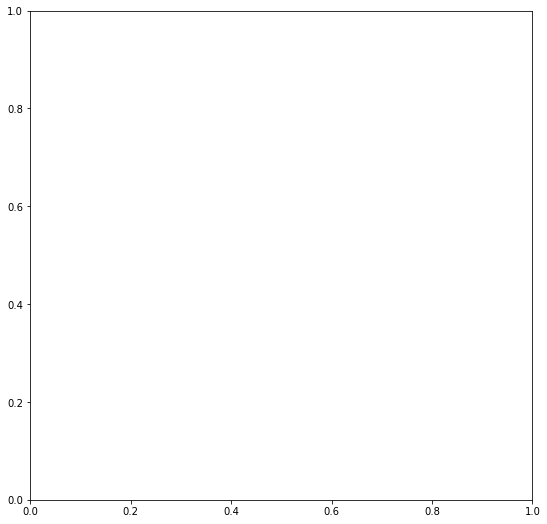

In [20]:
# Code for Scatter plot

print(np.shape(CTE2018_sf_ds.sf.values))

fig, ax = plt.subplots(figsize=(9,9))

scatter = ax.scatter(test_dat.sf.values, CTE2018_sf_ds.sf.values, c=[[colors.get(key) for key in test_dat.tc_region.values]for _ in range(104)])
# produce a legend with the unique colors from the scatter
L = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="TC_region")
# for i in range(5):
#     L.get_texts()[i].set_text(np.unique(test_dat.tc_region.values)[i])
ax.add_artist(L)
ax.set_ylabel('Model output')
ax.set_xlabel('Target output')
ax.set_title('CTE2018')

In [21]:
monthly_sf_ds

<xarray.Dataset>
Dimensions:  (regions: 9798, time: 104)
Coordinates:
  * regions  (regions) float64 1.0 2.0 3.0 4.0 ... 9.833e+03 9.834e+03 9.835e+03
    month    (time) int64 1 1 1 1 2 2 2 2 3 3 ... 10 10 11 11 11 11 12 12 12 12
  * time     (time) datetime64[ns] 2019-01-05 2019-01-12 ... 2020-12-26
Data variables:
    sf       (time, regions) float64 0.8703 1.012 0.9967 ... 0.8704 1.037 1.0

In [22]:
month_indeces = sf_dat_arr.time.values.astype('datetime64[M]').astype(int) % 12 + 1
monthly_sf

<xarray.Dataset>
Dimensions:  (regions: 9798, month: 12)
Coordinates:
  * regions  (regions) float64 1.0 2.0 3.0 4.0 ... 9.833e+03 9.834e+03 9.835e+03
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sf       (month, regions) float64 0.8703 1.012 0.9967 ... 0.8704 1.037 1.0

In [161]:
def er_to_global(ds):
    
    sf_landscape = np.ones(np.shape(all_regiondict[1.0]))
    for region in ds.ecoregion.values:
        delta_sf = ds.sel(ecoregion=region).sf.values - 1 # -1 is needed in order to capture the change in sf, which allows it to be added to sf_ds containting a matrix on only ones
        sf_landscape += all_regiondict[float(region)] * delta_sf
    return sf_landscape
        
def write_ds_to_files(data_sets, variables, state_vec_ds):
    if not os.path.isdir(ds_ready_for_transport_dir):
        os.makedirs(ds_ready_for_transport_dir)
        
    if len(np.unique([len(d.time.values) for d in data_sets]))!= 1:
        print(f'Tried saving data from datasets with different lenghts: {[len(d.time.values) for d in data_sets]}')
    n_weeks = len(data_sets[0].time)
    

    for i in range(len(SF_FILES)-n_weeks, len(SF_FILES)):
        combined_ds = xr.Dataset()
        f = SF_FILES[i]
        t = extract_date(f)
        print(f'date:{t} --> associated dates: \n{[extract_date(f) for f in SF_FILES[i-4:i+1]]}')
        for ds, var in zip(data_sets, variables):
            var_name = 'sf_'+var
            if t not in ds.time.values:
                print('-------ERROR: requested time not present within the dataset of estimates scaling factors--------')
                raise SystemExit
            dat_arr = np.ones(NPARAMS)
            dat = xr.DataArray(name=var_name, data = np.ones(NPARAMS), dims=['nparameters'], coords = {'nparameters': range(1, NPARAMS+1)})
            ds = ds.sel(time=t)
            for param in ds.regions.values:
                param = int(float(param))
                dat.loc[dict(nparameters = param)] = ds.sf.sel(regions= param)
                
            dat = xr.DataArray(name=var_name, data=dat, dims=['nparameters'], coords={'nparameters':dat.nparameters.values}).astype('float32')
            dat.attrs['Description'] = 'Global landscape of background scaling vector using the ' + var + ' method.'
            dat.attrs['Units'] = 'None'
            combined_ds['sf_'+var] = dat
            
        opt = get_state_vec(f, state_vec_ds)
        opt = opt.rename('sf_opt')
        opt = opt.rename({'regions':'nparameters'})
        opt_arr = xr.DataArray(name=var_name, data = np.ones(NPARAMS), dims=['nparameters'], coords = {'nparameters': range(1, NPARAMS+1)})
        for param in opt.nparameters.values:
            
            param = int(float(param))
            opt_arr.loc[dict(nparameters = param)] = opt.sel(nparameters= param)

        combined_ds['sf_optimised'] = opt_arr

        prior = xr.DataArray(name='prior_sf', data=np.ones(np.shape(opt_arr)), dims=['nparameters'], coords={'nparameters':dat.nparameters.values}).astype('float32')
        combined_ds['sf_prior'] = prior
            
        print(combined_ds)
        #print(combined_ds)
        file_dir = ds_ready_for_transport_dir + pd.to_datetime(t).strftime('%Y%m%d') + '/'
        if not os.path.isdir(file_dir):
            os.makedirs(file_dir)
        
        
        file_path = file_dir + 'prior_sv_' + pd.to_datetime(t).strftime('%Y%m%d') + '.nc'
        combined_ds.to_netcdf(file_path)
        os.chmod(file_path, 0o777) # Needed for setting permissions after writing


                

In [152]:
opt = get_state_vec(SF_FILES[0], state_elem_ds)
opt = opt.rename('sf_opt')
opt = opt.rename({'regions':'nparameters'})
#opt = opt.swap_dims({'regions':'nparameters'})

opt.sel(nparameters=4)

<xarray.DataArray 'sf_opt' ()>
array(0.9067456, dtype=float32)
Coordinates:
    nparameters  float64 4.0

In [51]:
with xr.open_dataset(state_vec_file) as ds:
    var_ds.regions.rename('eco_regions'), var_ds.grid_cell_weight

In [162]:
write_ds_to_files([CTE2018_sf_ds, monthly_sf_ds], ['CTE2018', 'monthly_avg'], state_elem_ds)

date:2019-01-05 00:00:00 --> associated dates: 
[Timestamp('2018-12-08 00:00:00'), Timestamp('2018-12-15 00:00:00'), Timestamp('2018-12-22 00:00:00'), Timestamp('2018-12-29 00:00:00'), Timestamp('2019-01-05 00:00:00')]
<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 2.379 2.918 2.752 ... 1.368 0.8038 1.0
    sf_monthly_avg  (nparameters) float32 0.8703 1.012 0.9967 ... 1.198 1.0
    sf_optimised    (nparameters) float64 2.073 2.13 0.9039 ... 1.535 0.5092 1.0
    sf_prior        (nparameters) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
date:2019-01-12 00:00:00 --> associated dates: 
[Timestamp('2018-12-15 00:00:00'), Timestamp('2018-12-22 00:00:00'), Timestamp('2018-12-29 00:00:00'), Timestamp('2019-01-05 00:00:00'), Timestamp('2019-01-12 00:00:00')]
<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * npara

<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 2.668 1.694 1.331 ... 0.3083 1.674 1.0
    sf_monthly_avg  (nparameters) float32 0.4348 0.5795 0.4621 ... 1.819 1.0
    sf_optimised    (nparameters) float64 2.792 2.267 2.42 ... 0.515 1.896 1.0
    sf_prior        (nparameters) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
date:2019-04-06 00:00:00 --> associated dates: 
[Timestamp('2019-03-09 00:00:00'), Timestamp('2019-03-16 00:00:00'), Timestamp('2019-03-23 00:00:00'), Timestamp('2019-03-30 00:00:00'), Timestamp('2019-04-06 00:00:00')]
<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 2.091 1.874 1.969 ... 1.064 0.9226 1.0
    sf_monthly_avg  (nparameters) float32 1.05 1.40

<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 2.809 3.264 2.162 ... 1.616 0.4503 1.0
    sf_monthly_avg  (nparameters) float32 1.479 1.48 1.71 ... 1.82 -0.1465 1.0
    sf_optimised    (nparameters) float64 5.003 6.304 5.528 ... 1.409 0.9292 1.0
    sf_prior        (nparameters) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
date:2019-06-29 00:00:00 --> associated dates: 
[Timestamp('2019-06-01 00:00:00'), Timestamp('2019-06-08 00:00:00'), Timestamp('2019-06-15 00:00:00'), Timestamp('2019-06-22 00:00:00'), Timestamp('2019-06-29 00:00:00')]
<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 2.172 1.685 0.8717 ... -0.3172 1.0
    sf_monthly_avg  (nparameters) float32 1.479 1.4

<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 1.227 1.732 1.946 ... 1.061 1.065 1.0
    sf_monthly_avg  (nparameters) float32 1.405 1.349 0.9278 ... 0.3009 1.0
    sf_optimised    (nparameters) float64 -0.2126 1.241 -1.281 ... 0.67 1.0
    sf_prior        (nparameters) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
date:2019-09-21 00:00:00 --> associated dates: 
[Timestamp('2019-08-24 00:00:00'), Timestamp('2019-08-31 00:00:00'), Timestamp('2019-09-07 00:00:00'), Timestamp('2019-09-14 00:00:00'), Timestamp('2019-09-21 00:00:00')]
<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 1.617 1.845 2.531 ... 0.9101 1.0
    sf_monthly_avg  (nparameters) float32 1.405 1.349 0.9278 .

<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 0.8119 0.92 0.6491 ... 1.019 1.0
    sf_monthly_avg  (nparameters) float32 0.433 0.4966 0.4751 ... 1.037 1.0
    sf_optimised    (nparameters) float64 1.01 -0.3848 -1.465 ... 1.37 1.039 1.0
    sf_prior        (nparameters) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
date:2019-12-14 00:00:00 --> associated dates: 
[Timestamp('2019-11-16 00:00:00'), Timestamp('2019-11-23 00:00:00'), Timestamp('2019-11-30 00:00:00'), Timestamp('2019-12-07 00:00:00'), Timestamp('2019-12-14 00:00:00')]
<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 0.8023 0.5071 0.2037 ... 0.997 1.0
    sf_monthly_avg  (nparameters) float32 0.433 0.4966 0.475

<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 0.3702 0.8294 0.7737 ... 1.328 1.0
    sf_monthly_avg  (nparameters) float32 1.203 1.025 1.351 ... 0.5046 1.454 1.0
    sf_optimised    (nparameters) float64 -1.532 -1.413 -1.248 ... 0.9481 1.0
    sf_prior        (nparameters) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
date:2020-03-07 00:00:00 --> associated dates: 
[Timestamp('2020-02-08 00:00:00'), Timestamp('2020-02-15 00:00:00'), Timestamp('2020-02-22 00:00:00'), Timestamp('2020-02-29 00:00:00'), Timestamp('2020-03-07 00:00:00')]
<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 0.3943 1.175 1.562 ... 1.211 1.0
    sf_monthly_avg  (nparameters) float32 0.4348 0.5795 0.

<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 1.659 1.382 2.318 ... 1.338 0.5428 1.0
    sf_monthly_avg  (nparameters) float32 1.391 1.373 1.136 ... 1.436 0.3002 1.0
    sf_optimised    (nparameters) float64 0.5831 1.137 0.7183 ... -1.813 1.0
    sf_prior        (nparameters) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
date:2020-05-30 00:00:00 --> associated dates: 
[Timestamp('2020-05-02 00:00:00'), Timestamp('2020-05-09 00:00:00'), Timestamp('2020-05-16 00:00:00'), Timestamp('2020-05-23 00:00:00'), Timestamp('2020-05-30 00:00:00')]
<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 0.3809 1.058 2.563 ... 0.004487 1.0
    sf_monthly_avg  (nparameters) float32 1.391 1.37

<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 1.405 0.8906 0.8931 ... -0.05365 1.0
    sf_monthly_avg  (nparameters) float32 1.351 1.251 1.048 ... 1.51 -0.1323 1.0
    sf_optimised    (nparameters) float64 2.863 2.705 0.6658 ... -0.4487 1.0
    sf_prior        (nparameters) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
date:2020-08-22 00:00:00 --> associated dates: 
[Timestamp('2020-07-25 00:00:00'), Timestamp('2020-08-01 00:00:00'), Timestamp('2020-08-08 00:00:00'), Timestamp('2020-08-15 00:00:00'), Timestamp('2020-08-22 00:00:00')]
<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 1.58 1.604 0.8543 ... 1.056 0.3725 1.0
    sf_monthly_avg  (nparameters) float32 1.351 1.2

<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 1.201 0.8195 0.7301 ... 0.7354 1.0
    sf_monthly_avg  (nparameters) float32 0.3594 0.5241 0.7323 ... 0.8369 1.0
    sf_optimised    (nparameters) float64 2.015 1.068 1.25 ... 0.7833 1.109 1.0
    sf_prior        (nparameters) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
date:2020-11-14 00:00:00 --> associated dates: 
[Timestamp('2020-10-17 00:00:00'), Timestamp('2020-10-24 00:00:00'), Timestamp('2020-10-31 00:00:00'), Timestamp('2020-11-07 00:00:00'), Timestamp('2020-11-14 00:00:00')]
<xarray.Dataset>
Dimensions:         (nparameters: 9835)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
Data variables:
    sf_CTE2018      (nparameters) float32 1.278 1.172 1.138 ... 0.9392 1.0
    sf_monthly_avg  (nparameters) float32 0.3594 0.5241 0.7

In [25]:
print(SF_FILES)

['/projects/0/ctdas/awoude/Ritten/flux_data/flux1x1_2000010100_2000010800.nc', '/projects/0/ctdas/awoude/Ritten/flux_data/flux1x1_2000010800_2000011500.nc', '/projects/0/ctdas/awoude/Ritten/flux_data/flux1x1_2000011500_2000012200.nc', '/projects/0/ctdas/awoude/Ritten/flux_data/flux1x1_2000012200_2000012900.nc', '/projects/0/ctdas/awoude/Ritten/flux_data/flux1x1_2000012900_2000020500.nc', '/projects/0/ctdas/awoude/Ritten/flux_data/flux1x1_2000020500_2000021200.nc', '/projects/0/ctdas/awoude/Ritten/flux_data/flux1x1_2000021200_2000021900.nc', '/projects/0/ctdas/awoude/Ritten/flux_data/flux1x1_2000021900_2000022600.nc', '/projects/0/ctdas/awoude/Ritten/flux_data/flux1x1_2000022600_2000030400.nc', '/projects/0/ctdas/awoude/Ritten/flux_data/flux1x1_2000030400_2000031100.nc', '/projects/0/ctdas/awoude/Ritten/flux_data/flux1x1_2000031100_2000031800.nc', '/projects/0/ctdas/awoude/Ritten/flux_data/flux1x1_2000031800_2000032500.nc', '/projects/0/ctdas/awoude/Ritten/flux_data/flux1x1_2000032500_2

In [188]:
with xr.open_dataset('/gpfs/work1/0/ctdas/awoude/Ritten/transport/20201219/prior_sv_20201219.nc') as ds:
    print(ds)

<xarray.Dataset>
Dimensions:         (nparameters: 9835, nlag: 1)
Coordinates:
  * nparameters     (nparameters) int64 1 2 3 4 5 6 ... 9831 9832 9833 9834 9835
  * nlag            (nlag) datetime64[ns] 2020-12-19
Data variables:
    sf_CTE2018      (nlag, nparameters) float32 ...
    sf_monthly_avg  (nlag, nparameters) float32 ...


In [144]:
print(str.split(SF_FILES[0], sep='/')[-1])

flux1x1_2000010100_2000010800.nc


2019-01-05T00:00:00.000000000


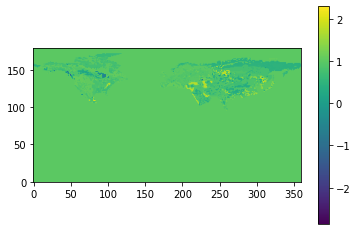

Current implementation withing CTE2018
<xarray.DataArray 'sf_landscape' (lat: 180, lon: 360)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    Description:  global landscape of scaling background scaling vectors
    Opt_method:   Current implementation withing CTE2018
2019-01-12T00:00:00.000000000


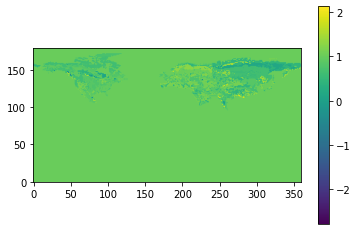

Current implementation withing CTE2018
<xarray.DataArray 'sf_landscape' (lat: 180, lon: 360)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    Description:  global landscape of scaling background scaling vectors
    Opt_method:   Current implementation withing CTE2018
2019-01-19T00:00:00.000000000


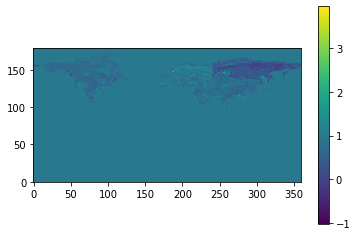

Current implementation withing CTE2018
<xarray.DataArray 'sf_landscape' (lat: 180, lon: 360)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    Description:  global landscape of scaling background scaling vectors
    Opt_method:   Current implementation withing CTE2018
2019-01-26T00:00:00.000000000


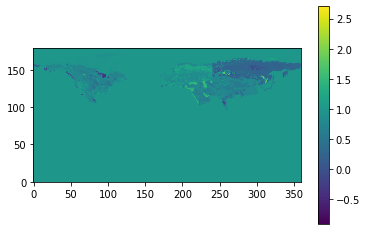

Current implementation withing CTE2018
<xarray.DataArray 'sf_landscape' (lat: 180, lon: 360)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    Description:  global landscape of scaling background scaling vectors
    Opt_method:   Current implementation withing CTE2018
2019-02-02T00:00:00.000000000


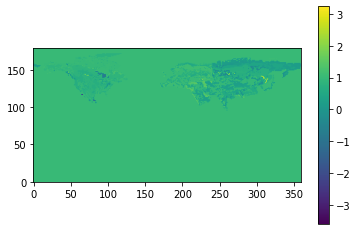

Current implementation withing CTE2018
<xarray.DataArray 'sf_landscape' (lat: 180, lon: 360)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    Description:  global landscape of scaling background scaling vectors
    Opt_method:   Current implementation withing CTE2018


In [110]:
#print(all_regiondict)
write_ds_to_files(CTE2018_sf_ds)

# Linear Regression stuff

In [9]:
def make_input_ds(ds):
    # .unique([date.month for date in ds.time.values]))
    months = ds.time.values.astype('datetime64[M]').astype(int) % 12 + 1
    one_hot = pd.get_dummies(months)
    x = xr.DataArray(name='one_hot_month', data=one_hot.values, dims=['time','one_hot'], coords={'one_hot':np.arange(1,13,1), 'time':ds.time.values})
    x.attrs['Description'] = 'One hot encoding of each month of a set of scaling factors.'
    return xr.merge([ds,x])

In [16]:

# Aggregated by ecoregion:
data = sf_dat_arr

# Plain state-vector:
# data = weekly_sv

input_ds = make_input_ds(data)

'''
In order to combine data from multiple parameters, use the line below:
'''
# input_ds = input_ds.to_stacked_array("input_arr", sample_dims=["time"])

'\nIn order to combine data from multiple parameters, use the line below:\n'

In [17]:
train_dat = input_ds.sel(time=slice(pd.to_datetime(20000101, format='%Y%m%d'), pd.to_datetime(20190101, format='%Y%m%d')))
test_dat = input_ds.sel(time=slice(pd.to_datetime(20190101, format='%Y%m%d'), pd.to_datetime(20210101, format='%Y%m%d')))



In [43]:
[t.astype('int') for t in train_dat.time.values.astype('datetime64[Y]')]

[30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 30,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 31,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 32,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,
 33,


In [35]:
np.unique(train_dat.time.astype('datetime64[M]'))

array(['2000-01-01T00:00:00.000000000', '2000-02-01T00:00:00.000000000',
       '2000-03-01T00:00:00.000000000', '2000-04-01T00:00:00.000000000',
       '2000-05-01T00:00:00.000000000', '2000-06-01T00:00:00.000000000',
       '2000-07-01T00:00:00.000000000', '2000-08-01T00:00:00.000000000',
       '2000-09-01T00:00:00.000000000', '2000-10-01T00:00:00.000000000',
       '2000-11-01T00:00:00.000000000', '2000-12-01T00:00:00.000000000',
       '2001-01-01T00:00:00.000000000', '2001-02-01T00:00:00.000000000',
       '2001-03-01T00:00:00.000000000', '2001-04-01T00:00:00.000000000',
       '2001-05-01T00:00:00.000000000', '2001-06-01T00:00:00.000000000',
       '2001-07-01T00:00:00.000000000', '2001-08-01T00:00:00.000000000',
       '2001-09-01T00:00:00.000000000', '2001-10-01T00:00:00.000000000',
       '2001-11-01T00:00:00.000000000', '2001-12-01T00:00:00.000000000',
       '2002-01-01T00:00:00.000000000', '2002-02-01T00:00:00.000000000',
       '2002-03-01T00:00:00.000000000', '2002-04-01

In [18]:
train_pred = train_dat.isel(time=slice(None,-1))
train_pred = train_pred.to_stacked_array("input_vec", sample_dims=["time"])
train_target = train_dat.isel(time=slice(1, None)).sf

test_pred = test_dat.isel(time=slice(None,-1))
test_pred = test_pred.to_stacked_array("input_vec", sample_dims=["time"])
test_target = test_dat.isel(time=slice(1, None)).sf

In [15]:
train_pred

<xarray.DataArray 'sf' (time: 991, input_vec: 9810)>
array([[-1.13899422, -0.40715319,  3.08963633, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72610188,  1.02900028,  0.8129912 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.53964245,  0.46649936,  0.12577882, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.73495531,  5.4081769 ,  4.13617373, ...,  0.        ,
         0.        ,  1.        ],
       [ 2.9721415 ,  3.98039508,  3.58951449, ...,  0.        ,
         0.        ,  1.        ],
       [ 3.16390061,  3.77352333,  3.66542745, ...,  0.        ,
         0.        ,  1.        ]])
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2018-12-22
  * input_vec  (input_vec) MultiIndex
  - variable   (input_vec) object 'sf' 'sf' ... 'one_hot_month' 'one_hot_month'
  - regions    (input_vec) float64 1.0 2.0 3.0 4.0 5.0 ... nan nan nan nan nan
  - one_hot    (input_vec) float64 nan nan nan nan nan ... 9.0 10.0 11.0 12.0
Attributes:
    Description:  Weekly analysed state vector
    Units:        None

In [16]:
test_pred

<xarray.DataArray 'sf' (time: 103, input_vec: 9810)>
array([[ 2.07302475,  2.12999201,  0.90393758, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.28533626,  3.04560351,  2.54890347, ...,  0.        ,
         0.        ,  0.        ],
       [ 3.68988895,  1.27093065,  1.74939466, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 2.28725362,  0.6053341 ,  1.60476863, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.66622865,  1.87580526,  2.07583857, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26539034, -0.04203299,  0.38370159, ...,  0.        ,
         0.        ,  1.        ]])
Coordinates:
  * time       (time) datetime64[ns] 2019-01-05 2019-01-12 ... 2020-12-19
  * input_vec  (input_vec) MultiIndex
  - variable   (input_vec) object 'sf' 'sf' ... 'one_hot_month' 'one_hot_month'
  - regions    (input_vec) float64 1.0 2.0 3.0 4.0 5.0 ... nan nan nan nan nan
  - one_hot    (input_vec) float64 nan nan nan nan nan ... 9.0 10.0 11.0 12.0
Attributes:
    Description:  Weekly analysed state vector
    Units:        None

In [19]:
lin_mod = LinearRegression().fit(train_pred.values, train_target.values)


In [20]:
print(f'R^2: {metrics.r2_score(test_target.values, lin_mod.predict(test_pred.values))}')
print(f'MAE: {metrics.mean_absolute_error(test_target.values, lin_mod.predict(test_pred.values))}')
print(f'MSE: {metrics.mean_squared_error(test_target.values, lin_mod.predict(test_pred.values))}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(test_target.values, lin_mod.predict(test_pred.values)))}')


R^2: -0.17258296649321092
MAE: 0.7735832333564758
MSE: 2.6555802822113037
RMSE: 1.629595160484314


In [ ]:
print(train_pred)

In [21]:
train_pred = train_dat
train_pred = train_pred.one_hot_month
train_target = train_dat.sf

test_pred = test_dat
test_pred = test_pred.one_hot_month
test_target = test_dat.sf

In [18]:
print(train_pred)
print(train_target)
print(test_pred)
print(test_target)

<xarray.DataArray 'one_hot_month' (time: 992, one_hot: 12)>
array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]], dtype=uint8)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2018-12-29
  * one_hot  (one_hot) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    Description:  One hot encoding of each month of a set of scaling factors.
<xarray.DataArray 'sf' (time: 992, regions: 9798)>
[9719616 values with dtype=float64]
Coordinates:
  * regions  (regions) float64 1.0 2.0 3.0 4.0 ... 9.833e+03 9.834e+03 9.835e+03
  * time     (time) datetime64[ns] 2000-01-01 2000-01-08 ... 2018-12-29
Attributes:
    Description:  Weekly analysed state vector
    Units:        None
<xarray.DataArray 'one_hot_month' (time: 104, one_hot: 12)>
array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],


In [22]:
lin_mod_2 = LinearRegression().fit(train_pred.values, train_target.values)

In [23]:
print(f'R^2: {metrics.r2_score(test_target.values, lin_mod_2.predict(test_pred.values))}')
print(f'MAE: {metrics.mean_absolute_error(test_target.values, lin_mod_2.predict(test_pred.values))}')
print(f'MSE: {metrics.mean_squared_error(test_target.values, lin_mod_2.predict(test_pred.values))}')
print(f'RMSE: {np.sqrt(metrics.mean_squared_error(test_target.values, lin_mod_2.predict(test_pred.values)))}')

R^2: 0.013378552599429893
MAE: 0.7013143899337735
MSE: 2.044551300093653
RMSE: 1.429878071757747


In [44]:
import pickle as pkl

file_name = '/gpfs/work1/0/ctdas/awoude/Ritten/predictor_vars/lsp-t2m-swvl1_2000-2019_day.pkl'
with open(file_name, 'rb') as f:
    data2 = pkl.load(f)

In [46]:
print(data2.df)

                                                          lsp  \
2000-01-01  [[1.3971119e-07, 1.3971119e-07, 1.3971119e-07,...   
2000-01-08  [[4.9410176e-07, 4.9410176e-07, 4.9410176e-07,...   
2000-01-15  [[4.293052e-07, 4.293052e-07, 4.293052e-07, 4....   
2000-01-22  [[2.1250318e-07, 2.1250318e-07, 2.1250318e-07,...   
2000-01-29  [[6.478925e-07, 6.478925e-07, 6.478925e-07, 6....   
...                                                       ...   
2019-11-30  [[2.7633922e-07, 2.7633922e-07, 2.7633922e-07,...   
2019-12-07  [[9.536922e-08, 9.536922e-08, 9.536922e-08, 9....   
2019-12-14  [[2.555138e-07, 2.555138e-07, 2.555138e-07, 2....   
2019-12-21  [[5.883951e-07, 5.883951e-07, 5.883951e-07, 5....   
2020-01-04  [[1.8861319e-07, 1.8861319e-07, 1.8861319e-07,...   

                                                          t2m  \
2000-01-01  [[240.61723, 240.61723, 240.61723, 240.61723, ...   
2000-01-08  [[241.49135, 241.49135, 241.49135, 241.49135, ...   
2000-01-15  [[242.92197,